In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch.distributions.dirichlet import Dirichlet
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from torch.optim.lr_scheduler import StepLR

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix

from sklearn.metrics import ConfusionMatrixDisplay

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.models import resnet18

import evidence_loss
import uncertain_fusion

import cv2
from PIL import Image


PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count()/2)
LOGGER_NAME = 'ZOOM_MNIST'

In [2]:
np.random.dirichlet([30,10])

array([0.69371133, 0.30628867])

## ZOOM MNIST Dataloader 

In [3]:

class Zoom_MNIST(MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False):
        super(Zoom_MNIST, self).__init__(root,  train=train,
                                         download=download,
                                         transform=transform,
                                    target_transform=target_transform)
        self.zoom_images = 3
    
    @staticmethod
    def create_zoom_images(img):
        '''
        returns list of images 
        '''
        original_size = 28
        
        #Randomly select 3 image sizes by using dirichlet stick breaking
        image_sizes = (np.random.dirichlet([30,10,10])*28).astype(int)
        #image_sizes = (np.random.dirichlet([30,10])*28).astype(int)
        size = 0
        x = int(np.random.rand() * 28)
        y = int(np.random.rand() * 28)
        
        output_images = []

        for i, image_size in enumerate(image_sizes):
            size +=image_size
            if (x + size)>original_size:
                x  = x - (x + size - original_size)
            if (y + size)>original_size:
                y = y - (y + size - original_size)
            canvas = np.zeros((original_size, original_size), dtype=np.uint8)
            small_img = cv2.resize(img.numpy().reshape(original_size,original_size, 1), (size,size))
            canvas[ y:y+small_img.shape[0], x:x+small_img.shape[1]] = small_img
            output_images.append(canvas.reshape(original_size,original_size))
        return output_images
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        images = self.create_zoom_images(img)
        
        out_images=[]
        for img in images:
            pil_img = Image.fromarray(img, mode='L')

            if self.transform is not None:
                out_images.append(self.transform(img))

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        
        return out_images, target



In [4]:
transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
zoom_mnist_dataset = Zoom_MNIST(root=".", train=False, transform=transform )
images, label = zoom_mnist_dataset[0]
dl = DataLoader(zoom_mnist_dataset, batch_size=5, num_workers=NUM_WORKERS)



torch.Size([1, 28, 28])
tensor(2.8088) tensor(-0.4242)
torch.Size([1, 28, 28])
tensor(2.8088) tensor(-0.4242)
torch.Size([1, 28, 28])
tensor(2.8088) tensor(-0.4242)


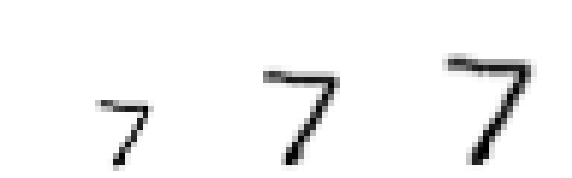

In [5]:
plt.style.use('seaborn-white')
plt.figure(figsize=(10, 8))
for j, img in enumerate(images):
    print (img.shape)
    print (img.max(), img.min())
    plt.subplot(1, 3, j+1)
    plt.imshow(img.numpy().squeeze())  # convert CHW -> HWC
    plt.axis("off")

In [6]:
m = Dirichlet(torch.tensor([10, 10]))
m.entropy()

tensor(-0.7983)

tensor(2.7960) tensor(-0.4242)
tensor(2.7960) tensor(-0.4242)
tensor(2.8088) tensor(-0.4242)
tensor(2.7960) tensor(-0.4242)
tensor(2.7960) tensor(-0.4242)
tensor(2.8215) tensor(-0.4242)
tensor(2.7324) tensor(-0.4242)
tensor(2.7706) tensor(-0.4242)
tensor(2.7451) tensor(-0.4242)
tensor(2.8088) tensor(-0.4242)
tensor(2.8088) tensor(-0.4242)
tensor(2.8088) tensor(-0.4242)
tensor(2.7451) tensor(-0.4242)
tensor(2.7960) tensor(-0.4242)
tensor(2.7960) tensor(-0.4242)


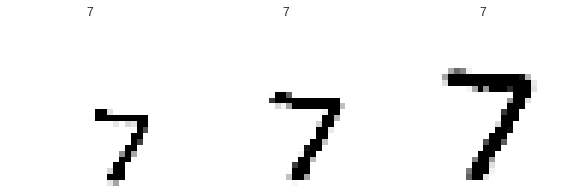

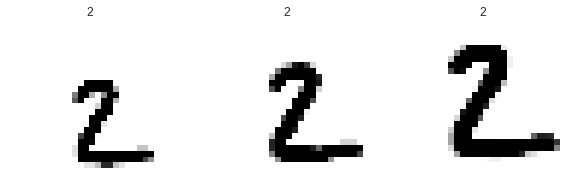

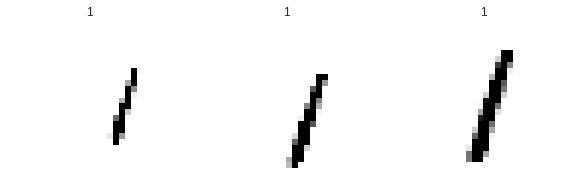

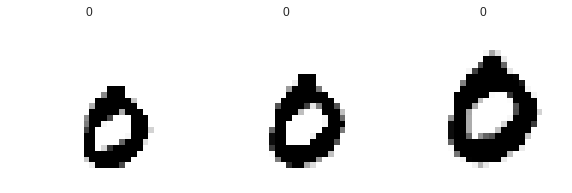

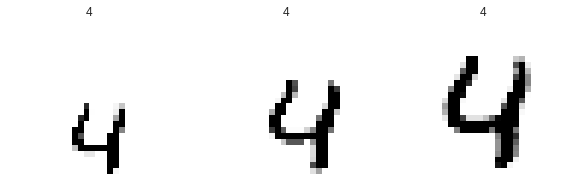

In [7]:
num_classes = 10
batch_images, labels = next(iter(dl))

for i, lable in enumerate(labels):
    plt.figure(figsize=(10, 8))
    for j, images in enumerate( batch_images):
        #logits = self(images)
        #alpha = F.relu(logits) + 1
        #preds = torch.argmax(alpha, dim=1)
        #uncertainty = num_classes / alpha.sum(dim=1)
        #drichlet_uncertainty = Dirichlet(alpha)
        plt.subplot(1, len(batch_images), j+1)
        print (images[i].max(), images[i].min())
        plt.imshow(images[i].numpy().squeeze(), vmin=0, vmax=1)  # convert CHW -> HWC
        plt.title(lable.item())
        plt.axis("off")

## MNIST Module

In [41]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.loss = evidence_loss.edl_mse_loss

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.RandomAffine(degrees=0,translate=(0.2,0.2),scale=(0.5,1.2)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        self.val_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )
        #self.model = resnet18(num_classes=10)
        # Have ResNet model take in grayscale rather than RGB
        #self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.val_accuracy = Accuracy()
        self.test_0_accuracy = Accuracy()
        self.test_1_accuracy = Accuracy()
        self.test_2_accuracy = Accuracy()
        self.test_accuracy = [self.test_0_accuracy,
                             self.test_1_accuracy,
                             self.test_2_accuracy]
        
        self.train_cm = ConfusionMatrix(num_classes=self.num_classes, normalize='true')
        self.valid_cm = ConfusionMatrix(num_classes=self.num_classes, normalize='true')
        
        self.DS_combine = uncertain_fusion.DempsterSchaferCombine(self.num_classes)
        self.mean_combine = uncertain_fusion.MeanUncertainty(self.num_classes)
        self.sum_combine = uncertain_fusion.SumUncertainty(self.num_classes)
        self.bayesian = uncertain_fusion.EffectiveProbability(confusion_matrix = np.ones((self.num_classes, 
                                                                                          self.num_classes)))
        self.dampster = uncertain_fusion.EffectiveProbability(confusion_matrix = np.ones((self.num_classes, 
                                                                                          self.num_classes)),
                                                                 fusion_type='dampster')
        self.conv_1d = torch.nn.Sequential(
                          torch.nn.Conv2d(in_channels=2*self.num_classes, 
                                       out_channels=self.num_classes, 
                                       kernel_size=1, 
                                       device=self.device),
                        )
        
        
        self.DS_combine_accuracy = Accuracy()
        self.mean_combine_accuracy = Accuracy()
        self.sum_combine_accuracy = Accuracy()
        self.bayes_combine_accuracy = Accuracy()
        self.dampster_combine_accuracy = Accuracy()
                                                                         
        
        self.fusion_methods = [self.DS_combine, 
                               self.mean_combine, 
                               self.sum_combine,
                               self.bayesian ,
                                self.dampster]
        self.fusion_names = ['DS_combine', 'mean', 'sum', 'bayes', 'dampster']
        self.combine_accuracy = [self.DS_combine_accuracy, 
                                 self.mean_combine_accuracy, 
                                 self.sum_combine_accuracy, 
                                 self.bayes_combine_accuracy,
                                 self.dampster_combine_accuracy
                                 ]
        
      
    def forward(self, x):
        x = self.model(x)
        return x
        #return F.log_softmax(x, dim=1)
        
    def logits_transformation(self, logits):
        logits = F.softmax(logits, dim=1)
        #logits = F.sigmoid(logits)
        logits = logits * 200
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ##Experiment with lgoits
        logits = self.logits_transformation(logits)
        #########################
        #nllloss = F.nll_loss(F.log_softmax(logits, dim=1), y)
        y = F.one_hot(y.to(torch.long), self.num_classes)
        loss = evidence_loss.edl_mse_loss(logits, y, self.current_epoch, self.num_classes, 1)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ##Experiment with lgoits
        logits = self.logits_transformation(logits)
        #########################
        
        y = F.one_hot(y.to(torch.long), self.num_classes)
        loss = evidence_loss.edl_mse_loss(logits, y, self.current_epoch, self.num_classes, 1)
        #loss = F.nll_loss(logits, y)
        alpha = F.relu(logits) + 1
        preds = torch.argmax(alpha, dim=1)
        self.val_accuracy.update(preds, y.argmax(dim=1))
        
        self.train_cm(preds, y.argmax(dim=1))

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val/loss", loss, prog_bar=True)
        
        #self.logger.experiment.add_scalars('Accuracy', {'val': self.val_accuracy.compute()},self.global_step)
        self.log("val/accuracy", self.val_accuracy, prog_bar=True)
        


    def validation_epoch_end(self, outputs):
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig, ax = plt.subplots(figsize=(20,20))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.train_cm.compute().cpu().numpy())
        disp.plot(ax=ax)
        # log figure
        self.logger.experiment.add_figure('val/epoch_confmat', fig, global_step=self.global_step)
        
        self.train_cm_numpy =  self.train_cm.compute().cpu().numpy()
    
        self.train_cm.reset()
        self.bayesian = uncertain_fusion.EffectiveProbability(confusion_matrix = self.train_cm_numpy)
        self.dampster = uncertain_fusion.EffectiveProbability(confusion_matrix = self.train_cm_numpy,
                                                                 fusion_type='dampster')
        #self.dampster = uncertain_fusion.EffectiveProbability(confusion_matrix = cm, fusion_type='dampster')


    def test_step(self, batch, batch_idx):
        list_images, labels = batch
        labels = F.one_hot(labels.to(torch.long), self.num_classes)
        
        prev_alpha = None
        zoom_images = 3
        threshold = 0.2
        if batch_idx  % 10== 0:
            fig = plt.figure(figsize=[6, 5])
            fig, axs = plt.subplots(5, gridspec_kw={"height_ratios": [5, 1, 1, 10, 10]})
            rimgs = np.zeros((28, 28 * zoom_images))
            scores = np.zeros((1, num_classes))
            fusion_scores = np.zeros((1, num_classes))
            classifications = []
            fusion_output = []
            lu = []
            fusion_lu = []
            lp = []
            fusion_lp = []
            ldeg = []
            
        for j, batch_images in enumerate( list_images):
            logits = self(batch_images)
            ##Experiment with lgoits
            logits = self.logits_transformation(logits)
            #########################
            loss = evidence_loss.edl_mse_loss(logits, labels, self.current_epoch, self.num_classes, 1)
            #loss = F.nll_loss(logits, labels)
            alpha = F.relu(logits) + 1
            preds = torch.argmax(alpha, dim=1)
            self.test_accuracy[j].update(preds, labels.argmax(dim=1))
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            probs = alpha /  torch.sum(alpha, dim=1, keepdim=True)
            if batch_idx  % 10 == 0:
                rimgs[:, j*28:(j+1)*28] = batch_images[0].detach().cpu().numpy().reshape(28,28)
                classifications.append(preds[0].item())
                scores += probs[0].detach().cpu().numpy() >= threshold
                lu.append(uncertainty[0].item())
                ldeg.append(j)
                lp.append(probs[0].tolist())
            
            #self.logger.experiment.add_scalars('Accuracy',
            #                                   {'fusion/'+str(j): self.test_accuracy[j].compute()},
            #                                   self.global_step) 
            self.log("val/fusion/accuracy/"+str(j), self.test_accuracy[j], prog_bar=True)
            
            if prev_alpha is not None:
                for fuse, name, fuse_acc in zip(self.fusion_methods, 
                                                  self.fusion_names, 
                                                  self.combine_accuracy):
                    
                    fused_alpha = fuse(prev_alpha[name].to(self.device).to(torch.float), alpha)
                    fused_alpha = F.relu(fused_alpha) + 1
                    preds = torch.argmax(fused_alpha, dim=1)
                    uncertainty = self.num_classes / torch.sum(fused_alpha, dim=1, keepdim=True)
                    probs = fused_alpha /  torch.sum(fused_alpha, dim=1, keepdim=True)
                    fuse_acc.update(preds.to('cpu'), labels.argmax(dim=1).to('cpu'))
                    
                    self.log("val/fusion/accuracy/"+name, fuse_acc, prog_bar=True)
            
                    prev_alpha[name] = fused_alpha
                if batch_idx  % 10== 0:
                    fusion_output.append(preds[0].item())
                    fusion_scores += probs[0].detach().cpu().numpy() >= threshold
                    print ("Uncertainty of 0 img", uncertainty[0].item() )
                    print ("Fused alpha  of 0 img", fused_alpha[0])
                    fusion_lu.append(uncertainty[0].item())
                    fusion_lp.append(probs[0].tolist())
                   
            else:
                prev_alpha={}
                for name in self.fusion_names:
                    prev_alpha[name] = alpha
                    
                if batch_idx % 10 == 0:
                    fusion_output.append("-")
                    fusion_scores += probs[0].detach().cpu().numpy() >= threshold
                    #fusion_scores += np.zeros((1, num_classes)) >= threshold
                    fusion_lu.append(uncertainty[0].item())
                    fusion_lp.append(probs[0].tolist())
                   
                    
        if batch_idx % 10 == 0:
            #logits = self(images)
            #alpha = F.relu(logits) + 1
            #preds = torch.argmax(alpha, dim=1)
            #uncertainty = num_classes / alpha.sum(dim=1)
            #drichlet_uncertainty = Dirichlet(alpha)
            #plt.subplot(1, len(list_images), j+1)
            axs[0].imshow(rimgs, vmin=0, vmax=1)  # convert CHW -> HWC
            plt.title(labels[0].argmax().to('cpu').item())
            axs[0].axis("off")
            
            empty_lst = []
            empty_lst.append(classifications)
            axs[1].table(cellText=empty_lst, bbox=[0, 1, 1, 1])
            axs[1].axis("off")
            
            empty_lst = []
            empty_lst.append(fusion_output)
            axs[2].table(cellText=empty_lst, bbox=[0, 1, 1, 1])
            axs[2].axis("off")
            
            axs[3].plot(ldeg, lu, marker="<", c="black")
            
            labels = np.arange(10)[scores[0].astype(bool)]
            lp = np.array(lp)[:, labels]
            c = ["blue", "red", "brown", "purple", "cyan"]
            marker = ["s", "^", "o"]*2
            labels = labels.tolist()
            for i in range(len(labels)):
                print ("plot  lp ", lp[:, i])
                axs[3].plot(ldeg, lp[:, i], marker=marker[i], c=c[i])
            axs[3].set_ylim([0, 1])
            axs[3].legend(labels)
                
            fusion_labels = np.arange(10)[fusion_scores[0].astype(bool)]
            fusion_lp = np.array(fusion_lp)[:, fusion_labels]
            c = ["blue", "red", "brown", "purple", "cyan"]
            marker = ["s", "^", "o"]*2
            fusion_labels = fusion_labels.tolist()
            print ("fusion_labels ", fusion_labels)
            for i in range(len(fusion_labels)):
                print ("plot fusion lp ", fusion_lp[:, i])
                axs[4].plot(ldeg, fusion_lp[:, i], marker=marker[i], c=c[i])
            axs[4].plot(ldeg, fusion_lu, marker="<", c="black")
            
            axs[4].set_ylim([0, 1])
            axs[4].legend(labels)
            axs[4].set_xlim([0, 1])        
            
            
            # log figure
            self.logger.experiment.add_figure('sample', fig, global_step=self.global_step)

            

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test/loss", loss, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer=torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=1e-5)
        #scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=1, eta_min=1e-4, last_epoch=-1)
        #scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=2, eta_min=1e-4, last_epoch=-1)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
          
        return {'optimizer': optimizer,'lr_scheduler':scheduler}
        #return torch.optim.Adam(self.parameters(), lr=self.lr)

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
        Zoom_MNIST(self.data_dir, train=False, download=True)
        

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            #self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            self.mnist_zoom = Zoom_MNIST(self.data_dir, train=False, transform=self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.mnist_zoom, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [42]:
model = LitMNIST()


Initialized fusion type :  bayes
Initialized fusion type :  dampster


In [43]:
logger = TensorBoardLogger('./lightning_logs/', name=LOGGER_NAME)
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=2,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    #logger=CSVLogger(save_dir="logs/"),
    check_val_every_n_epoch=2,
    logger=logger
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type                   | Params
----------------------------------------------------------------------
0  | model                     | Sequential             | 55.1 K
1  | val_accuracy              | Accuracy               | 0     
2  | test_0_accuracy           | Accuracy               | 0     
3  | test_1_accuracy           | Accuracy               | 0     
4  | test_2_accuracy           | Accuracy               | 0     
5  | train_cm                  | ConfusionMatrix        | 0     
6  | valid_cm                  | ConfusionMatrix        | 0     
7  | DS_combine                | DempsterSchaferCombine | 0     
8  | mean_combine              | MeanUncertainty        | 0     
9  | sum_combine               | SumUncertainty         | 0     
10 | bayesian             

Sanity Checking: 0it [00:00, ?it/s]

Initialized fusion type :  bayes
Initialized fusion type :  dampster


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Initialized fusion type :  bayes
Initialized fusion type :  dampster


In [30]:
torch.save(model.model, 'zoom_mnist.pt')

In [31]:
model.model = torch.load( 'zoom_mnist.pt')
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

0.909090907859408 tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000], dtype=torch.float64)
0.909090907859408 tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000], dtype=torch.float64)
fusion_labels  []
0.909090907859408 tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000], dtype=torch.float64)
0.909090907859408 tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000], dtype=torch.float64)
fusion_labels  []
0.909090907859408 tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000], dtype=torch.float64)
0.909090907859408 tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000], dtype=torch.float64)
fusion_labels  []
0.909090907859408 tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000], dtype=torch.flo

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test/loss            │       1.3979148864746094       │
│     val/fusion/accuracy/0      │      0.09790000319480896       │
│     val/fusion/accuracy/1      │      0.09799999743700027       │
│     val/fusion/accuracy/2      │      0.09799999743700027       │
│ val/fusion/accuracy/DS_combine │      0.09790000319480896       │
│   val/fusion/accuracy/bayes    │      0.09794999659061432       │
│  val/fusion/accuracy/dampster  │      0.09794999659061432       │
│    val/fusion/accuracy/mean    │      0.09799999743700027       │
│    val/fusion/accuracy/sum     │      0.09794999659061432       │
└────────────────────────────────┴────────────────────────────────┘

[{'val/fusion/accuracy/0': 0.09790000319480896,
  'val/fusion/accuracy/1': 0.09799999743700027,
  'val/fusion/accuracy/DS_combine': 0.09790000319480896,
  'val/fusion/accuracy/mean': 0.09799999743700027,
  'val/fusion/accuracy/sum': 0.09794999659061432,
  'val/fusion/accuracy/bayes': 0.09794999659061432,
  'val/fusion/accuracy/dampster': 0.09794999659061432,
  'val/fusion/accuracy/2': 0.09799999743700027,
  'test/loss': 1.3979148864746094}]

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

## 1 D fusion Training 

In [41]:
class OneDLitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.loss = evidence_loss.edl_mse_loss

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.RandomAffine(degrees=0,translate=(0.2,0.2),scale=(0.5,1.0)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        self.val_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )


        self.model = resnet18( num_classes=10)
        self.model.eval()
            
        # Have ResNet model take in grayscale rather than RGB
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.val_accuracy = Accuracy()
        self.test_0_accuracy = Accuracy()
        self.test_1_accuracy = Accuracy()
        self.test_2_accuracy = Accuracy()
        self.test_accuracy = [self.test_0_accuracy,
                             self.test_1_accuracy,
                             self.test_2_accuracy]
        
        self.train_cm = ConfusionMatrix(num_classes=self.num_classes, normalize='true')
        self.valid_cm = ConfusionMatrix(num_classes=self.num_classes, normalize='true')
        
        
        self.fc_fusion = torch.nn.Linear(2*self.num_classes, self.num_classes,device=self.device )
        
        
        self.one_d_accuray = Accuracy()
        self.two_d_accuracy = Accuracy()
        
      
    def forward(self, x):
        x = self.model(x)
        return x
        #return F.log_softmax(x, dim=1)


    def common_epoch_step(self, batch, batch_idx, stage):
        list_images, labels = batch
        labels = F.one_hot(labels.to(torch.long), self.num_classes)
        
        prev_alpha = None
        for j, batch_images in enumerate( list_images):
            logits = self(batch_images)
            alpha = F.relu(logits) + 1
            preds = torch.argmax(alpha, dim=1)
            self.test_accuracy[j].update(preds, labels.argmax(dim=1))
            
            #self.logger.experiment.add_scalars('Accuracy',
            #                                   {'fusion/'+str(j): self.test_accuracy[j].compute()},
            #                                   self.global_step) 
            self.log(stage+"/accuracy/"+str(j), self.test_accuracy[j], prog_bar=True)
            
            if prev_alpha is not None:

                fused_alpha = torch.concat((prev_alpha.to(self.device).to(torch.float),alpha), dim=1)
                fused_alpha = self.fc_fusion(fused_alpha)
                preds = torch.argmax(fused_alpha, dim=1)
                
                #self.logger.experiment.add_scalars('Accuracy', 
                #                                   {'fusion'+name: fuse_acc.compute()},
                #                                   self.global_step) 
            
                prev_alpha = fused_alpha
                

            else:
                prev_alpha = alpha
            
        
        
                    
            
        loss = evidence_loss.edl_mse_loss(fused_alpha, labels, self.current_epoch, self.num_classes, 1)
        self.one_d_accuray.update(preds, labels.argmax(dim=1))
        self.log(stage+"/one D accuracy", self.one_d_accuray, prog_bar=True)
                
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log(stage+"/loss", loss, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.common_epoch_step(batch, batch_idx, 'train')
        
    def validation_step(self, batch, batch_idx):
        return self.common_epoch_step(batch, batch_idx, 'valid')
        
    def configure_optimizers(self):
        optimizer=torch.optim.AdamW(self.fc_fusion.parameters(), lr=0.001, weight_decay=1e-5)
        #scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=1, eta_min=1e-4, last_epoch=-1)
        #scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=2, eta_min=1e-4, last_epoch=-1)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
          
        return {'optimizer': optimizer,'lr_scheduler':scheduler}
        #return torch.optim.Adam(self.parameters(), lr=self.lr)

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        Zoom_MNIST(self.data_dir, train=False, download=True)
        

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.mnist_zoom_train = Zoom_MNIST(self.data_dir, train=True, transform=self.val_transform)
            self.mnist_zoom_valid = Zoom_MNIST(self.data_dir, train=False, transform=self.val_transform)

        

    def train_dataloader(self):
        return DataLoader(self.mnist_zoom_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.mnist_zoom_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

  

In [42]:
target = torch.empty(3, dtype=torch.long).random_(5)
target

tensor([3, 0, 3])

In [43]:
model = OneDLitMNIST()
model.model = torch.load('zoom_mnist.pt')
model.model.eval()
for param in model.model.parameters():
    param.requires_grad = False

logger = TensorBoardLogger('./lightning_logs/', name=LOGGER_NAME)
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=2,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    #logger=CSVLogger(save_dir="logs/"),
    check_val_every_n_epoch=2,
    logger=logger
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | model           | ResNet          | 11.2 M
1 | val_accuracy    | Accuracy        | 0     
2 | test_0_accuracy | Accuracy        | 0     
3 | test_1_accuracy | Accuracy        | 0     
4 | test_2_accuracy | Accuracy        | 0     
5 | train_cm        | ConfusionMatrix | 0     
6 | valid_cm        | ConfusionMatrix | 0     
7 | fc_fusion       | Linear          | 210   
8 | one_d_accuray   | Accuracy        | 0     
9 | two_d_accuracy  | Accuracy        | 0     
----------------------------------------------------
210       Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.702    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [88]:
class DampsterLitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.loss = evidence_loss.edl_mse_loss

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.RandomAffine(degrees=0,translate=(0.2,0.2),scale=(0.5,1.0)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        self.val_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )


        self.model = resnet18( num_classes=10)
            
        # Have ResNet model take in grayscale rather than RGB
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        

        self.val_accuracy = Accuracy()
        self.test_0_accuracy = Accuracy()
        self.test_1_accuracy = Accuracy()
        self.test_2_accuracy = Accuracy()
        self.test_accuracy = [self.test_0_accuracy,
                             self.test_1_accuracy,
                             self.test_2_accuracy]
        
        self.train_cm = ConfusionMatrix(num_classes=self.num_classes, normalize='true')
        self.valid_cm = ConfusionMatrix(num_classes=self.num_classes, normalize='true')
        
        
        #self.fc_fusion = torch.nn.Linear(2*self.num_classes, self.num_classes,device=self.device )
        self.DS_combine = uncertain_fusion.DempsterSchaferCombine(self.num_classes)
        
        self.one_d_accuray = Accuracy()
        self.two_d_accuracy = Accuracy()
        
      
    def forward(self, x):
        x = self.model(x)
        return x
        #return F.log_softmax(x, dim=1)


    def common_epoch_step(self, batch, batch_idx, stage):
        list_images, labels = batch
        labels = F.one_hot(labels.to(torch.long), self.num_classes)
        
        prev_alpha = None
        for j, batch_images in enumerate( list_images):
            logits = self(batch_images)
            alpha = F.relu(logits) + 1
            preds = torch.argmax(alpha, dim=1)
            self.test_accuracy[j].update(preds, labels.argmax(dim=1))
            
            #self.logger.experiment.add_scalars('Accuracy',
            #                                   {'fusion/'+str(j): self.test_accuracy[j].compute()},
            #                                   self.global_step) 
            self.log(stage+"/accuracy/"+str(j), self.test_accuracy[j], prog_bar=True)
            
            if prev_alpha is not None:

                #fused_alpha = torch.concat((prev_alpha.to(self.device).to(torch.float),alpha), dim=1)
                fused_alpha = self.DS_combine(prev_alpha.to(self.device).to(torch.float), alpha)
                preds = torch.argmax(fused_alpha, dim=1)
                
                #self.logger.experiment.add_scalars('Accuracy', 
                #                                   {'fusion'+name: fuse_acc.compute()},
                #                                   self.global_step) 
            
                prev_alpha = fused_alpha
                

            else:
                prev_alpha = alpha
            
           
        loss = evidence_loss.edl_mse_loss(fused_alpha, labels, self.current_epoch, self.num_classes, 1)
        self.one_d_accuray.update(preds, labels.argmax(dim=1))
        self.log(stage+"/one D accuracy", self.one_d_accuray, prog_bar=True)
                
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log(stage+"/loss", loss, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.common_epoch_step(batch, batch_idx, 'train')
        
    def validation_step(self, batch, batch_idx):
        return self.common_epoch_step(batch, batch_idx, 'valid')

    def test_step(self, batch, batch_idx):
        list_images, labels = batch
        labels = F.one_hot(labels.to(torch.long), self.num_classes)
        
        prev_alpha = None
        zoom_images = 3
        threshold = 0.2
        if batch_idx  % 10== 0:
            fig = plt.figure(figsize=[6, 5])
            fig, axs = plt.subplots(5, gridspec_kw={"height_ratios": [5, 1, 1, 10, 10]})
            rimgs = np.zeros((28, 28 * zoom_images))
            scores = np.zeros((1, num_classes))
            fusion_scores = np.zeros((1, num_classes))
            classifications = []
            fusion_output = []
            lu = []
            fusion_lu = []
            lp = []
            fusion_lp = []
            ldeg = []
            
        for j, batch_images in enumerate( list_images):
            logits = self(batch_images)
            loss = evidence_loss.edl_mse_loss(logits, labels, self.current_epoch, self.num_classes, 5)
            #loss = F.nll_loss(logits, labels)
            alpha = F.relu(logits) + 1
            preds = torch.argmax(alpha, dim=1)
            self.test_accuracy[j].update(preds, labels.argmax(dim=1))
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            if 0 == j:#Find the image with mx uncertainty in the first image only
                max_uncertain_args = torch.argmax(uncertainty)
            probs = alpha /  torch.sum(alpha, dim=1, keepdim=True)
            if batch_idx  % 10 == 0:
                
                rimgs[:, j*28:(j+1)*28] = batch_images[max_uncertain_args].detach().cpu().numpy().reshape(28,28)
                classifications.append(preds[max_uncertain_args].item())
                scores += probs[max_uncertain_args].detach().cpu().numpy() >= threshold
                lu.append(uncertainty[max_uncertain_args].item())
                ldeg.append(j)
                lp.append(probs[max_uncertain_args].tolist())
            
            #self.logger.experiment.add_scalars('Accuracy',
            #                                   {'fusion/'+str(j): self.test_accuracy[j].compute()},
            #                                   self.global_step) 
            self.log("test/fusion/accuracy/"+str(j), self.test_accuracy[j], prog_bar=True)
            if prev_alpha is not None:
                
                    
                fused_alpha = self.DS_combine(prev_alpha.to(self.device).to(torch.float), alpha)
                fused_alpha = F.relu(fused_alpha) + 1
                preds = torch.argmax(fused_alpha, dim=1)
                uncertainty = self.num_classes / torch.sum(fused_alpha, dim=1, keepdim=True)
                probs = fused_alpha /  torch.sum(fused_alpha, dim=1, keepdim=True)

                prev_alpha = fused_alpha
                if batch_idx  % 10== 0:
                    fusion_output.append(preds[max_uncertain_args].item())
                    fusion_scores += probs[max_uncertain_args].detach().cpu().numpy() >= threshold
                    print (uncertainty[max_uncertain_args].item(), fused_alpha[max_uncertain_args], )
                    fusion_lu.append(uncertainty[max_uncertain_args].item())
                    fusion_lp.append(probs[max_uncertain_args].tolist())
                   
            else:
                prev_alpha = alpha
                uncertainty = self.num_classes / torch.sum(alpha, dim=1, keepdim=True)
                probs = alpha /  torch.sum(alpha, dim=1, keepdim=True)
    
                if batch_idx % 10 == 0:
                    fusion_output.append("-")
                    fusion_scores += probs[max_uncertain_args].detach().cpu().numpy() >= threshold
                    #fusion_scores += np.zeros((1, num_classes)) >= threshold
                    fusion_lu.append(uncertainty[0].item())
                    fusion_lp.append(probs[max_uncertain_args].tolist())
                    
        self.one_d_accuray.update(preds, labels.argmax(dim=1))
        self.log("test/fusion/accuracy/one_D_accuracy", self.one_d_accuray, prog_bar=True)
                   
                    
        if batch_idx % 10 == 0:
            #logits = self(images)
            #alpha = F.relu(logits) + 1
            #preds = torch.argmax(alpha, dim=1)
            #uncertainty = num_classes / alpha.sum(dim=1)
            #drichlet_uncertainty = Dirichlet(alpha)
            #plt.subplot(1, len(list_images), j+1)
            axs[0].imshow(rimgs, vmin=0, vmax=1)  # convert CHW -> HWC
            plt.title(labels[max_uncertain_args].argmax().to('cpu').item())
            axs[0].axis("off")
            
            empty_lst = []
            empty_lst.append(classifications)
            axs[1].table(cellText=empty_lst, bbox=[0, 1, 1, 1])
            axs[1].axis("off")
            
            empty_lst = []
            empty_lst.append(fusion_output)
            axs[2].table(cellText=empty_lst, bbox=[0, 1, 1, 1])
            axs[2].axis("off")
            
            axs[3].plot(ldeg, lu, marker="<", c="black")
            
            labels = np.arange(10)[scores[0].astype(bool)]
            lp = np.array(lp)[:, labels]
            c = ["blue", "red", "brown", "purple", "cyan"]
            marker = ["s", "^", "o"]*2
            labels = labels.tolist()
            for i in range(len(labels)):
                print ("plot  lp ", lp[:, i])
                axs[3].plot(ldeg, lp[:, i], marker=marker[i], c=c[i])
            axs[3].set_ylim([0, 1])
            axs[3].legend(labels)
                
            fusion_labels = np.arange(10)[fusion_scores[0].astype(bool)]
            fusion_lp = np.array(fusion_lp)[:, fusion_labels]
            c = ["blue", "red", "brown", "purple", "cyan"]
            marker = ["s", "^", "o"]*2
            fusion_labels = fusion_labels.tolist()
            print ("fusion_labels ", fusion_labels)
            for i in range(len(fusion_labels)):
                print ("plot fusion lp ", fusion_lp[:, i])
                axs[4].plot(ldeg, fusion_lp[:, i], marker=marker[i], c=c[i])
            axs[4].plot(ldeg, fusion_lu, marker="<", c="black")
            
            axs[4].set_ylim([0, 1])
            axs[4].legend(labels)
            axs[4].set_xlim([0, 1])        
            
            
            # log figure
            self.logger.experiment.add_figure('sample_'+str(batch_idx), fig, global_step=self.global_step)

            
        
    def configure_optimizers(self):
        optimizer=torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=1e-5)
        #scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=1, eta_min=1e-4, last_epoch=-1)
        #scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=2, eta_min=1e-4, last_epoch=-1)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
          
        return {'optimizer': optimizer,'lr_scheduler':scheduler}
        #return torch.optim.Adam(self.parameters(), lr=self.lr)
        

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        Zoom_MNIST(self.data_dir, train=False, download=True)
        

    def setup(self, stage=None):
        print ("setup stage ", stage)
        # Assign train/val datasets for use in dataloaders
        #if stage == "fit" or stage is None:
        self.mnist_zoom_train = Zoom_MNIST(self.data_dir, train=True, transform=self.val_transform)
        
        self.mnist_zoom_valid = Zoom_MNIST(self.data_dir, train=False, transform=self.val_transform)

        

    def train_dataloader(self):
        return DataLoader(self.mnist_zoom_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.mnist_zoom_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.mnist_zoom_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
  

In [89]:
model = DampsterLitMNIST()
#model.model = torch.load('zoom_mnist.pt')

logger = TensorBoardLogger('./lightning_logs/', name=LOGGER_NAME)
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=2,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    #logger=CSVLogger(save_dir="logs/"),
    check_val_every_n_epoch=2,
    logger=logger
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params
-----------------------------------------------------------
0 | model           | ResNet                 | 11.2 M
1 | val_accuracy    | Accuracy               | 0     
2 | test_0_accuracy | Accuracy               | 0     
3 | test_1_accuracy | Accuracy               | 0     
4 | test_2_accuracy | Accuracy               | 0     
5 | train_cm        | ConfusionMatrix        | 0     
6 | valid_cm        | ConfusionMatrix        | 0     
7 | DS_combine      | DempsterSchaferCombine | 0     
8 | one_d_accuray   | Accuracy               | 0     
9 | two_d_accuracy  | Accuracy               | 0     
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total e

setup stage  TrainerFn.FITTING


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [90]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


setup stage  TrainerFn.TESTING


Testing: 0it [00:00, ?it/s]

0.2721967399120331 tensor([ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,
         2.0000, 18.7381], device='cuda:0')
0.08796845376491547 tensor([ 3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,
         3.0000, 86.6771], device='cuda:0')
plot  lp  [0.1        0.66340208 0.73632145]
fusion_labels  [9]
plot fusion lp  [0.1        0.51004589 0.76248515]
0.2080220878124237 tensor([ 2.0000,  2.0000,  2.0000, 30.0718,  2.0000,  2.0000,  2.0000,  2.0000,
         2.0000,  2.0000], device='cuda:0')
0.06647595018148422 tensor([  3.0000,   3.0000,   3.0000, 123.4303,   3.0000,   3.0000,   3.0000,
          3.0000,   3.0000,   3.0000], device='cuda:0')
plot  lp  [0.1        0.76360464 0.73244661]
fusion_labels  [3]
plot fusion lp  [0.1        0.62556022 0.82051492]
0.21273541450500488 tensor([ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000, 29.0067,
         2.0000,  2.0000], device='cuda:0')
0.06737329810857773 tensor([  3.0000,   3.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/fusion/accuracy/0        │         0.6639999747276306          │
│       test/fusion/accuracy/1        │         0.9383999705314636          │
│       test/fusion/accuracy/2        │         0.9682999849319458          │
│ test/fusion/accuracy/one_D_accuracy │         0.9778000116348267          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/fusion/accuracy/0': 0.6639999747276306,
  'test/fusion/accuracy/1': 0.9383999705314636,
  'test/fusion/accuracy/2': 0.9682999849319458,
  'test/fusion/accuracy/one_D_accuracy': 0.9778000116348267}]

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>